<font color = blue><font size = 6> 실험설명 </font></font><br>
Pytorch의 모델 구성의 기본을 알아가면서 DLinear를 implementation한 깃허브를 참고해서 이해하고(중간에 RNN 구현으로 넘어갔다가 온다) 실험에 적용시켜본다

오히려 RNN과 데이터 구성방식이 달라서 오류가 계속 발생했음

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# 이 모듈에는 torch.nn 라이브러리의 모든 함수가 포함되어 있다 다양한 손실 및
# 활성화 함수 뿐만 아니라, 풀링(pooling) 함수와 같이 신경망을 만드는데 편리한 몇 가지
# 함수도 여기에서 찾을 수 있다.
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
from torch import FloatTensor
from sklearn.preprocessing import MinMaxScaler

[출처]<br>
https://github.com/cure-lab/LTSF-Linear/blob/main/models/DLinear.py <br>
https://anweh.tistory.com/21

In [7]:
# Pytorch로 설게하는 신경망은 반드시 따라야 하는 구조가 있다

'''
1. torch.nn.Module을 상속해야 한다
2. __init()__과 forward()를 override 해야한다.
    (1) override: torch.nn.Module(부모클래스)에서 정의한 메소드를 override 해야한다
    (2) __init()__ 에서는 모델에서 사용될 module(nn.Linear, nn.Conv2d), activation function
    (nn.functional.relu, nn.functional.sigmoid)등을 정의한다
    (3) forward()에서는 모델에서 실행되어야하는 계산을 정의한다. backward 계산은 backward()를
    이용시에 Pytorch가 알아서 해주니깐 forward()만을 정의해주면 된다
    input을 넣어서 어떤 계산을 진행해서 output이 나올지를 정의해준다고 이해하면 된다
'''
class moving_avg(nn.Module):
    "M.A.는 시계열의 trend에 집중하는 것을 막는다"
    def __init__(self,kernel_size,stride):
        super(moving_avg,self).__init__()
        # super(Model_Name,self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size = kernel_size, stride = stride, padding =0)
        # pooling 계산을 하는 1차원 평균으로 pooling계산
    
    def forward(self,x):
        " time series의 양 쪽 끝을 padding 한다"
        print(x[:,0:1])
        front = x[:,0:1,:].repeat(1,(self.kernel_size-1)//2,1)
        # Repeats this tensor along the specified dimensions.
        #print("front",front)
        
        end = x[:,-1,:].repeat(1,(self.kernel_size-1)//2,1)
        #print("end",end)
        
# front와 end를 추가해서 moving average를 계산해서 공백이 없도록
        
        x = torch.cat([front, x, end], dim=1)
        #print("cat",x,x.size())
        
        #print('before avg',x.permute(0,2,1))
        x = self.avg(x.permute(0,2,1)) #pooling 계산
        #print(x)
        
        x = x.permute(0,2,1) # 원상복귀
        #print(x)
        return x

In [8]:
x=torch.FloatTensor([2,1,3,4]).view(1,-1,1) #4개의 데이터를 가진 것을 표현
print(x)
print('-----------------')
ma = moving_avg(3,1) 
x = ma.forward(x)
print(x)

tensor([[[2.],
         [1.],
         [3.],
         [4.]]])
-----------------
tensor([[[2.]]])
tensor([[[1.6667],
         [2.0000],
         [2.6667],
         [3.6667]]])


In [9]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        res = x - moving_mean 
        # Classical ma중에서 additive model
        print(res.permute(1,2,0).size())
        print('----')
        print(moving_mean.permute(1,2,0).size())
        return res.permute(1,2,0),moving_mean.permute(1,2,0)

In [10]:
x = torch.FloatTensor([1,2,3,4]).view(1,-1,1)
decomp = series_decomp(3) 
# kernel_size를 짝수로하면 오류 발생 (size가 맞지 않은 오류)
# 이경우는 짝수 ma를 두번진행하면 된다(아래 예시)
a,b=decomp.forward(x)

tensor([[[1.]]])
torch.Size([4, 1, 1])
----
torch.Size([4, 1, 1])


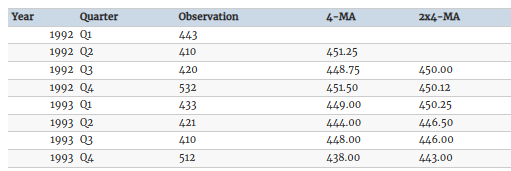
https://otexts.com/fpp2/moving-averages.html

In [40]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.seq_len = int(configs['DLinear_cfg1']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['DLinear_cfg1']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = bool(configs['DLinear_cfg1']['individual']) # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['DLinear_cfg1']['enc_in']) # 2) 이때 특성의개수
        
        if self.individual: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            
    def forward(self,x):
            # x의 size는 [Batch, Input_length, Channel]
            seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
            seasoanl_init,trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1) # 새로로 펼친걸 가로로 늘림
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
            if self.individual:
                seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
                trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
                for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                    seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                    trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
            else:
                seasonal_output = self.Linear_Seasonal(seasonal_init)    
                trend_output = self.Linear_Trend(trend_init)
            
            x = seasonal_output + trend_output
            return x.permute(0,2,1) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return
                    

torch.zeros parameter<br>
Args:<br>
    size (int...): a sequence of integers defining the shape of the output tensor.<br>
        Can be a variable number of arguments or a collection like a list or tuple.<br>

Keyword args:<br>
    out (Tensor, optional): the output tensor.<br>
    dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.<br>
        Default: if ``None``, uses a global default (see :func:`torch.set_default_tensor_type

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self,seq_len,pred_len,individual,enc_in): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.seq_len = seq_len # configure의 sequence length
        self.pred_len = pred_len # configure의 prediction length
        
        # Decomposition Kernel Size
        kernel_size = 5 #커널사이즈를 5로 변경
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = individual # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = enc_in # 2) 이때 특성의개수
        
        if self.individual: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
        

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decomposition(x)# res = seasonality 를 moving_mean은 trend를 의미
        # seasoanl_init,trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1) # 새로로 펼친걸 가로로 늘림
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
             # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                # 이때 RNN과 달리 한번에 학습을 진행하기 때문에 seq의 배열 자체가 feature가 됨
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # [batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)]로 변경해서 return

torch.Size([64, 1, 1])
1
torch.Size([64, 1])

In [8]:
torch.ones(2,1,3,dtype=float) # batch는 2 length는 1 input size=3 

tensor([[[1., 1., 1.]],

        [[1., 1., 1.]]], dtype=torch.float64)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# 이 모듈에는 torch.nn 라이브러리의 모든 함수가 포함되어 있다 다양한 손실 및
# 활성화 함수 뿐만 아니라, 풀링(pooling) 함수와 같이 신경망을 만드는데 편리한 몇 가지
# 함수도 여기에서 찾을 수 있다.
import numpy as np
import pandas as pd

In [14]:
data = pd.read_csv('../traffic/data/5.csv')
data

,service_name,datetime,volumn,packets,unknown
0,S201709282113260015,2018-07-25 00:00:00,92408,26971036,177711644
1,S201709282113260015,2018-07-25 00:01:00,92150,26948190,220370286
2,S201709282113260015,2018-07-25 00:02:00,94896,26238222,188035073
3,S201709282113260015,2018-07-25 00:03:00,92694,26087970,191997884
4,S201709282113260015,2018-07-25 00:04:00,93674,25314568,169497214
...,...,...,...,...,...
38875,S201709282113260015,2018-08-20 23:55:00,81521,23637112,138239574
38876,S201709282113260015,2018-08-20 23:56:00,83092,24617816,164460450
38877,S201709282113260015,2018-08-20 23:57:00,84873,25101336,173568370
38878,S201709282113260015,2018-08-20 23:58:00,81736,24181689,157334718


In [15]:
data.drop(columns=['service_name','packets','unknown'])

,datetime,volumn
0,2018-07-25 00:00:00,92408
1,2018-07-25 00:01:00,92150
2,2018-07-25 00:02:00,94896
3,2018-07-25 00:03:00,92694
4,2018-07-25 00:04:00,93674
...,...,...
38875,2018-08-20 23:55:00,81521
38876,2018-08-20 23:56:00,83092
38877,2018-08-20 23:57:00,84873
38878,2018-08-20 23:58:00,81736


In [16]:
scaler = MinMaxScaler()
data[['volumn']] = scaler.fit_transform(data[['volumn']])
data

,service_name,datetime,volumn,packets,unknown
0,S201709282113260015,2018-07-25 00:00:00,0.148677,26971036,177711644
1,S201709282113260015,2018-07-25 00:01:00,0.148146,26948190,220370286
2,S201709282113260015,2018-07-25 00:02:00,0.153802,26238222,188035073
3,S201709282113260015,2018-07-25 00:03:00,0.149266,26087970,191997884
4,S201709282113260015,2018-07-25 00:04:00,0.151285,25314568,169497214
...,...,...,...,...,...
38875,S201709282113260015,2018-08-20 23:55:00,0.126251,23637112,138239574
38876,S201709282113260015,2018-08-20 23:56:00,0.129487,24617816,164460450
38877,S201709282113260015,2018-08-20 23:57:00,0.133156,25101336,173568370
38878,S201709282113260015,2018-08-20 23:58:00,0.126694,24181689,157334718


<AxesSubplot: >

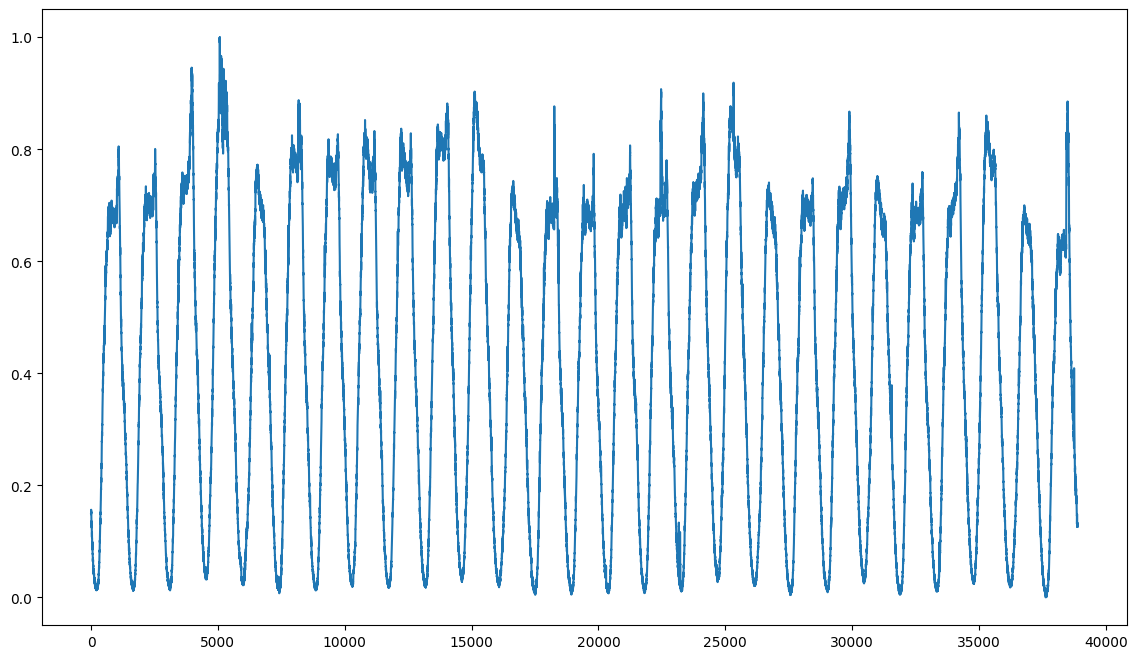

In [17]:
data['volumn'].plot(figsize=(14,8))

In [18]:
def seq_data(x,y,sequence_length,pred_len):
    seq_list = []
    target_list = []
    if (type(x)==list)|(type(x)==np.array):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length:i+sequence_length+pred_len].values)
    
    if type(x) == pd.Series:
        print(1)
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(y[i+sequence_length:i+sequence_length+pred_len].values)
#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).unsqueeze(1).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [19]:
split = 1440 # split까지 학습을 하게 되면 split-pred_len까지의 정답은 알려준셈이 된다
sequence_length = 1800
pred_len = 720
individual = True
enc_in = 1
device = torch.device("cuda:0")
X = data['volumn'].iloc[:-split]
Y = data['volumn']
x_seq, target = seq_data(x=X,y=Y,sequence_length=sequence_length,pred_len=pred_len)
x_seq,target = x_seq.permute(0,2,1),target.permute(0,2,1)
print(x_seq.shape,target.shape)

1


/tmp/ipykernel_3076118/764832783.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).unsqueeze(1).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


torch.Size([35640, 1800, 1]) torch.Size([35640, 720, 1])


In [20]:
device = torch.device("cuda:0")
torch_data = TensorDataset(x_seq,target)

In [21]:
batch_size = 32
train_loader = DataLoader(torch_data,batch_size = batch_size)

In [22]:
count =1
for i,j in train_loader:
    print(i.cpu().size())
    print(j.cpu().size())
    count+=1
print(count)

torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch

torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch.Size([32, 720, 1])
torch.Size([32, 1800, 1])
torch

https://velog.io/@leaps/Pytorch-1.-Config-module-%EB%A7%8C%EB%93%A4%EA%B8%B0

https://greeksharifa.github.io/pytorch/2018/11/10/pytorch-usage-03-How-to-Use-PyTorch/


In [41]:
model = Model(config).to(device)
criterion = nn.MSELoss()
num_epochs = 100
optimizer = optim.Adam(model.parameters(),lr=1e-5)

In [30]:
import time
count = 0
out_list = []
loss_graph = []
n = len(train_loader)
begin = time.time()
for epoch in range(num_epochs):

    running_loss = 0.0
    for dt in train_loader:
        seq,tg = dt
        
        out = model(seq)
  
        loss = criterion(out,tg)# 손실함수 계산
        
        optimizer.zero_grad() # optimizer 초기화
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
        count+=1
        
    loss_graph.append(running_loss/n)
    
    print('mse',running_loss/n) 

end = time.time()
#시간차
result = end - begin
print(count) # 64크기를 갖는 배치가 585개 있는데(마지막은 < 64) 이걸 50번 돌았

mse 0.04267194289049465
mse 0.007812895056335138
mse 0.007445786936255422
mse 0.00709672362516054
mse 0.006831578527664167
mse 0.006663498620852105
mse 0.0065744152032190025
mse 0.0065411824487282225
mse 0.006544968691460966
mse 0.006572043768824555
mse 0.006612676144986166
mse 0.0066600227536202225
mse 0.006709312962633984
mse 0.006757287972893472
mse 0.006801808743437299
mse 0.006841569889145168
mse 0.0068758816853929745
mse 0.0069044997304654136
mse 0.006927492331496701
mse 0.006945135810886279
mse 0.006957836220391208
mse 0.006966070204389472
mse 0.0069703423859155695
mse 0.006971155870241854
mse 0.006968992535001682
mse 0.006964301307171732
mse 0.006957491343396614
mse 0.006948929179799024
mse 0.006938939430915811
mse 0.006927805719426892
mse 0.006915773888288067
mse 0.006903055220753743
mse 0.006889829756149686
mse 0.006876250044815786
mse 0.006862443935725281
mse 0.006848518722539636
mse 0.0068345628752864524
mse 0.006820649296970983
mse 0.006806837226441519
mse 0.00679317449636

In [31]:
len(Y[-(sequence_length+pred_len):-(pred_len)].tolist())

1800

In [32]:
out_list = []


with torch.no_grad():
    model.eval()
    #if num==0:
    new_train=[Y[-(sequence_length+pred_len):-(pred_len)].tolist()]
#     else:
#         new_train = new_train[1:]+out.cpu().tolist()
        #print(type(new_train))
    new_tr = torch.FloatTensor(new_train).unsqueeze(2).to(device)
    out = model(new_tr)
#    out_list.append(out)
#   loss_graph.append(running_loss/n)
print(out)

tensor([[[ 6.2398e-01],
         [ 6.3140e-01],
         [ 6.3023e-01],
         [ 6.1485e-01],
         [ 6.2908e-01],
         [ 6.4364e-01],
         [ 6.3096e-01],
         [ 6.3303e-01],
         [ 6.2979e-01],
         [ 6.1053e-01],
         [ 6.2787e-01],
         [ 6.0108e-01],
         [ 6.2531e-01],
         [ 6.2159e-01],
         [ 6.0874e-01],
         [ 6.1389e-01],
         [ 6.0089e-01],
         [ 6.0721e-01],
         [ 5.8427e-01],
         [ 5.9276e-01],
         [ 6.0250e-01],
         [ 6.0188e-01],
         [ 5.8852e-01],
         [ 5.7513e-01],
         [ 5.9720e-01],
         [ 5.8624e-01],
         [ 5.7534e-01],
         [ 5.8208e-01],
         [ 5.8297e-01],
         [ 5.9217e-01],
         [ 5.8855e-01],
         [ 5.8496e-01],
         [ 5.8249e-01],
         [ 5.8240e-01],
         [ 5.8467e-01],
         [ 5.7890e-01],
         [ 5.6507e-01],
         [ 5.7170e-01],
         [ 5.6294e-01],
         [ 5.7486e-01],
         [ 5.6496e-01],
         [ 5.579

In [33]:
plot_data = np.array(out.cpu().tolist()).reshape(1,-1)[0]
plot_data

array([ 6.23977780e-01,  6.31398559e-01,  6.30231559e-01,  6.14849031e-01,
        6.29077196e-01,  6.43641770e-01,  6.30963027e-01,  6.33029640e-01,
        6.29789948e-01,  6.10533357e-01,  6.27865314e-01,  6.01075172e-01,
        6.25309050e-01,  6.21587157e-01,  6.08739793e-01,  6.13891602e-01,
        6.00894451e-01,  6.07208967e-01,  5.84269881e-01,  5.92759013e-01,
        6.02496207e-01,  6.01876855e-01,  5.88516653e-01,  5.75132728e-01,
        5.97202063e-01,  5.86244345e-01,  5.75338244e-01,  5.82077622e-01,
        5.82971513e-01,  5.92173815e-01,  5.88546097e-01,  5.84964216e-01,
        5.82490802e-01,  5.82398176e-01,  5.84667206e-01,  5.78903258e-01,
        5.65068245e-01,  5.71699917e-01,  5.62940061e-01,  5.74864745e-01,
        5.64960361e-01,  5.57896137e-01,  5.59222102e-01,  5.72857916e-01,
        5.62420845e-01,  5.61073005e-01,  5.53074300e-01,  5.57415426e-01,
        5.51926434e-01,  5.60636044e-01,  5.53229392e-01,  5.59563518e-01,
        5.56062579e-01,  

<font color = blue> Result3<br>아래의 값은 경험하지 못한 값이기 때문에 의미가 있음</font>

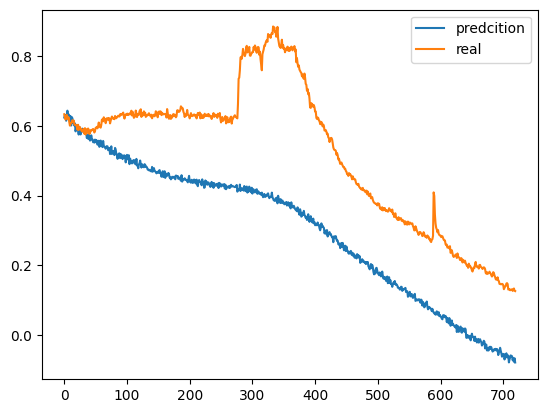

In [35]:
plot_data = np.array(out.cpu().tolist()).reshape(1,-1)[0]
plt.plot(np.arange(len(plot_data)),plot_data,label = 'predcition')
plt.plot(np.arange(len(plot_data)),Y[-720:],label = 'real')
plt.legend()

<font color = blue> Result1 </font><br>
데이터를 scale 전처리 말고 시간정보 제외 했을때 결과<br>
shuffle 안돌렸을때(돌리는게 결과가 좀더 나음)
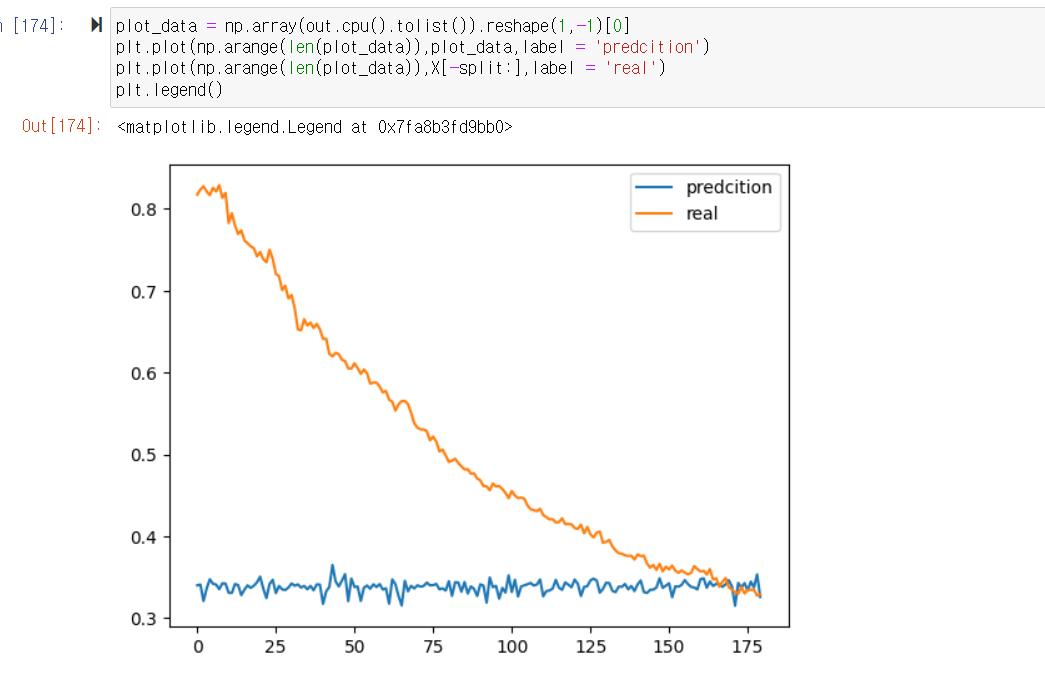


&rightarrow; Target Data를 잘못 대응시켜줘서 이상한 결과가 나옴

https://arxiv.org/pdf/2201.12886.pdf

<font color = blue> Result2 </font><br>
seq 수정후(1440학습후 360 예측)<br>
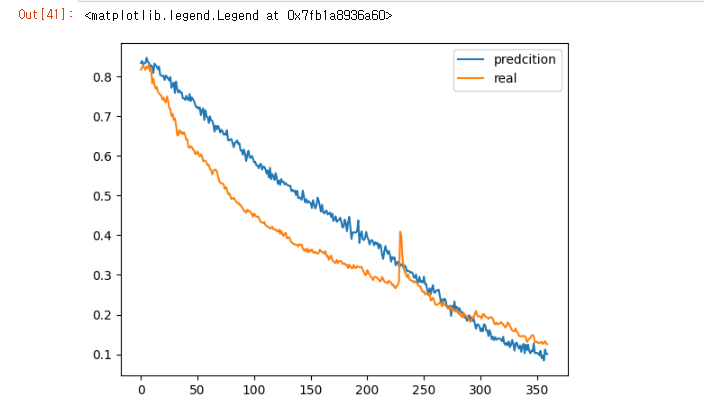

<font color = blue> 연구미팅 이후 configuration 사용</font>

In [42]:
import os
import configparser

config = configparser.ConfigParser()
print("work dir",os.getcwd())
print("separator",os.sep)

config.read(os.getcwd()+os.sep+'DLinear_cfg1',encoding = 'utf-8')
#configuration에 있는 속성을 사용할때 ['configfilename']['원하는 속성'] 하고 전체에 내가 받고 싶은 속성의 자료형을 씌워줘야한다

work dir /hdd_1/sjlee/Model_Implementation
separator /


['/hdd_1/sjlee/Model_Implementation/DLinear_cfg1']